# Deep Learning Font Classifier

### Introduction

This project develops a deep learning classifier to identify fonts in text images. The process involves:

1. **Image Preprocessing**: Using OpenCV to detect text boxes.
2. **Character Extraction**: Utilizing Pytesseract to extract individual characters.
3. **Font Classification**: Applying a Convolutional Neural Network (CNN) to classify the font of each character and determining the font of the text box through majority voting.


### Approach

- **Image Preprocessing**: Thresholding and dilation to enhance text regions, followed by contour detection for locating text boxes.
- **Character Extraction**: Bounding box identification and Region of Interest (ROI) extraction for each character.
- **Deep Learning Classification**: A custom CNN model classifies each character's font, and majority voting determines the font of the text box.



## 1.Test Data Generation with Multiple Words

To generate test data containing multiple words, we can follow these steps:



In [3]:
import os
import random
from PIL import Image, ImageDraw, ImageFont

# Define text
text = "Hello World!"

# Define font directory
font_directory = "fonts"

# Define output directory
output_directory = "output_images"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all font files in the directory
font_files = [f for f in os.listdir(font_directory) if f.endswith('.ttf')]

# Define font sizes
font_sizes = [64]

# Load all fonts
fonts = [ImageFont.truetype(os.path.join(font_directory, font_file), random.choice(font_sizes)) for font_file in font_files]

# Define image size
image_width = 1920
image_height = 720

# Define grid parameters
num_rows = 3
num_cols = 3
cell_width = image_width // num_cols
cell_height = image_height // num_rows

# Stretch scale for text boxes
# Create images with stretched text boxes
for i in range(10):  # Create 10 images
    # Create image
    image = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(image)

    # Shuffle fonts for variety
    random.shuffle(fonts)

    # Draw text in each cell of the grid and stretch vertically and horizontally
    for row in range(num_rows):
        for col in range(num_cols):
            # Randomly select font and size for the text
            font = random.choice(fonts)

            # Generate text box
            textbox = Image.new("RGB", (cell_width, cell_height), "white")
            textbox_draw = ImageDraw.Draw(textbox)
            text_width, text_height = font.getsize(text)
            x = (cell_width - text_width) // 2
            y = (cell_height - text_height) // 2
            textbox_draw.text((x, y), text, fill="black", font=font)
            # Calculate position to paste the text box on the image
            paste_x = col * cell_width
            paste_y = row * cell_height

            # Paste stretched text box onto the image
            image.paste(textbox, (paste_x, paste_y))

    # Save image to the output directory
    output_path = os.path.join(output_directory, f"hello_{i}.png")
    image.save(output_path)

print("Images with stretched text boxes created successfully and saved to the output folder!")


/tmp/ipykernel_105635/710198143.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(text)


Images with stretched text boxes created successfully and saved to the output folder!


## 2.Data Generation for DeepCNN Classifier Training

The following code is used to generate data for training a Deep Convolutional Neural Network (DeepCNN) classifier. The DeepCNN classifier is a type of neural network that is commonly used for image classification tasks.

I am taking individual letters as training data to train the model, this is done as a lot of letters are similar and we can take a cumulative score

In [4]:
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Define text
text = "Hello World!"

# Define font directory
font_directory = "fonts"

# Define output directory
output_directory = "training_data/output_stretched_textboxes"

# Define training data directory
training_directory = "training_data"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
os.makedirs(training_directory, exist_ok=True)

# List all font files in the directory
font_files = [f for f in os.listdir(font_directory) if f.endswith('.ttf')]

# Define font sizes
font_sizes = [64]

# Load all fonts
fonts = [ImageFont.truetype(os.path.join(font_directory, font_file), random.choice(font_sizes)) for font_file in font_files]

# Create training data file
with open(os.path.join(training_directory, "training_data.txt"), "w") as f:
    # Create stretched text boxes
    for i in range(1000):  # Create 1000 images
        # Shuffle fonts for variety
        random.shuffle(fonts)

        # Randomly select font for the image
        font = random.choice(fonts)
        
        for char in text:
            if char == " ":
                continue
            # Generate text box for each character
            textbox = Image.new("RGB", (64, 64), "white")  # Fixed size for simplicity
            textbox_draw = ImageDraw.Draw(textbox)
            # Randomly shift the position of the letter
            shift_x = random.randint(-10, 10)
            shift_y = random.randint(-10, 10)

            text_width, text_height = font.getsize(char)
            x = (64 - text_width+shift_x) // 2
            y = (64 - text_height+shift_y) // 2
            textbox_draw.text((x, y), char, fill="black", font=font)
            textbox_np = np.array(textbox)

            # Save the character image
            output_path = os.path.join(output_directory, f"{char}_font_{i}.png")
            cv2.imwrite(output_path, textbox_np)
            
            # Write the label to the training data file
            label = f"{char}_font_{i}.png \"{font.getname()[0]}\"\n"
            f.write(label)


/tmp/ipykernel_105635/1656628078.py:52: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(char)


## 3.Model and dataset creation

In [5]:
import os
import random
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(1, 64, 5, padding=2)  # Changed kernel size to 5 to accommodate 64x64 input
        self.pool = nn.MaxPool2d(2, 2)    # kernel size, stride
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)  # Changed kernel size to 5 to maintain feature map size
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted based on input size after pooling
        self.fc2 = nn.Linear(512, 8)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 16 * 16)  # Adjusted based on input size after pooling
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout layer with 0.5 probability
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Log softmax for output layer



# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir,data, labels, transform=None):
        self.data_dir = data_dir
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data[idx]
        image_path = os.path.join(self.data_dir, filename)
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image, label


def classes_to_one_hot(classes):
    # Get unique classes and sort them
    unique_classes = sorted(set(classes))
    
    # Create dictionary to store one-hot encoded tensors
    one_hot_dict = {}
    
    # Convert each class to one-hot encoding
    for i, class_name in enumerate(unique_classes):
        # Initialize one-hot tensor
        one_hot = torch.zeros(len(unique_classes))
        
        # Set corresponding index to 1
        one_hot[i] = 1
        
        # Store one-hot tensor in dictionary
        one_hot_dict[class_name] = one_hot
    
    return one_hot_dict

def labels_to_one_hot(labels, one_hot_dict):
    # Convert each label to one-hot encoding using the dictionary
    one_hot_labels = [one_hot_dict[label] for label in labels]
    
    return one_hot_labels
# Define paths
txt_file = 'training_data/training_data.txt'  # Path to your .txt file containing filenames and labels
data_dir = 'training_data/output_stretched_textboxes'  # Directory containing your image data

# Read labels from the .txt file
labels = {}
with open(txt_file, 'r') as file:
    for line in file:
        filename, label = line.strip().split(' "')
        labels[filename] = label

# Create lists of filenames and corresponding labels
filenames = list(labels.keys())
labels = list(labels.values())

num_classes = 8  # Set the number of classes
# Convert integer indices to one-hot encoded vectors
one_hot_dict = classes_to_one_hot(labels)
# Split dataset into training and testing sets. Stratify the split to maintain the same distribution of labels in both sets
one_hot_labels = labels_to_one_hot(labels, one_hot_dict)


In [6]:
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, one_hot_labels, test_size=0.2, stratify=labels)

# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Create datasets and data loaders
train_dataset = CustomDataset(data_dir,train_filenames, train_labels, transform=transform)
test_dataset = CustomDataset(data_dir,test_filenames, test_labels, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,pin_memory=True)

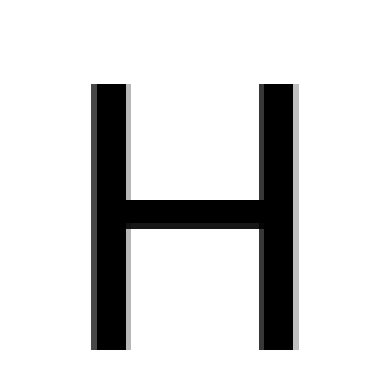

Sample Label: tensor([0., 0., 0., 0., 0., 0., 1., 0.])


In [7]:
import matplotlib.pyplot as plt

# Access a sample image and label from the dataset
sample_image, sample_label = next(iter(train_loader))

# Convert the image tensor to a NumPy array and plot it
plt.imshow(sample_image[0].squeeze(), cmap='gray')  # Assuming grayscale image
plt.axis('off')
plt.show()

# Check whether the label matches the image displayed
print("Sample Label:", sample_label[0])


## Training Script

The provided Python script is for training a model. 


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

# Define your model, loss function, optimizer, train_loader, and test_loader
best_validation_loss = float('inf')
train_losses = []
test_losses = []
# Initialize your model
model = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the maximum number of epochs and initialize a flag to monitor convergence
max_epochs = 30
converged = False

# Initialize variables to store previous training and test losses
prev_train_loss = float('inf')
prev_test_loss = float('inf')
best_loss = float('inf')
scale_factor = 1000000.0
# Keep training until convergence or reaching the maximum number of epochs
for epoch in range(max_epochs):
    # If the model has converged, break the loop
    if converged:
        break

    model.train()  # Set the model to train mode
    running_train_loss = 0.0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{max_epochs}', unit='batch'):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running training loss
        running_train_loss += loss.item() * images.size(0) * scale_factor

    # Compute average training loss for the epoch
    epoch_train_loss = running_train_loss/len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item() * images.size(0) * scale_factor

    # Compute average test loss for the epoch
    epoch_test_loss = running_test_loss/len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    patience = 5
    # Early stopping
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss

        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break



    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')


Epoch 1/30: 100%|██████████| 100/100 [00:04<00:00, 20.40batch/s]


Epoch 1/30, Train Loss: 1066313.1794, Test Loss: 482317.9722


Epoch 2/30: 100%|██████████| 100/100 [00:03<00:00, 25.42batch/s]


Epoch 2/30, Train Loss: 367541.7542, Test Loss: 238727.0629


Epoch 3/30: 100%|██████████| 100/100 [00:03<00:00, 26.44batch/s]


Epoch 3/30, Train Loss: 215241.4736, Test Loss: 105234.0606


Epoch 4/30: 100%|██████████| 100/100 [00:03<00:00, 26.52batch/s]


Epoch 4/30, Train Loss: 148587.1842, Test Loss: 95243.5325


Epoch 5/30: 100%|██████████| 100/100 [00:03<00:00, 26.46batch/s]


Epoch 5/30, Train Loss: 98820.4201, Test Loss: 98109.3856


Epoch 6/30: 100%|██████████| 100/100 [00:03<00:00, 27.06batch/s]


Epoch 6/30, Train Loss: 79806.1960, Test Loss: 35364.0124


Epoch 7/30: 100%|██████████| 100/100 [00:03<00:00, 26.77batch/s]


Epoch 7/30, Train Loss: 42039.5963, Test Loss: 16856.0891


Epoch 8/30: 100%|██████████| 100/100 [00:03<00:00, 26.87batch/s]


Epoch 8/30, Train Loss: 42100.0002, Test Loss: 55371.6179


Epoch 9/30: 100%|██████████| 100/100 [00:03<00:00, 26.68batch/s]


Epoch 9/30, Train Loss: 42098.3471, Test Loss: 18728.3883


Epoch 10/30: 100%|██████████| 100/100 [00:03<00:00, 26.18batch/s]


Epoch 10/30, Train Loss: 35517.0258, Test Loss: 70807.6296


Epoch 11/30: 100%|██████████| 100/100 [00:03<00:00, 26.45batch/s]


Epoch 11/30, Train Loss: 43650.9851, Test Loss: 42935.9081


Epoch 12/30: 100%|██████████| 100/100 [00:03<00:00, 26.91batch/s]


Epoch 12/30, Train Loss: 24752.2752, Test Loss: 8334.8585


Epoch 13/30: 100%|██████████| 100/100 [00:03<00:00, 26.80batch/s]


Epoch 13/30, Train Loss: 30218.3235, Test Loss: 5706.1617


Epoch 14/30: 100%|██████████| 100/100 [00:03<00:00, 26.90batch/s]


Epoch 14/30, Train Loss: 23325.3495, Test Loss: 5439.5113


Epoch 15/30: 100%|██████████| 100/100 [00:03<00:00, 26.99batch/s]


Epoch 15/30, Train Loss: 16065.6113, Test Loss: 8835.5297


Epoch 16/30: 100%|██████████| 100/100 [00:03<00:00, 26.86batch/s]


Epoch 16/30, Train Loss: 12194.9709, Test Loss: 7182.0610


Epoch 17/30: 100%|██████████| 100/100 [00:03<00:00, 26.17batch/s]


Epoch 17/30, Train Loss: 10178.3883, Test Loss: 6531.8935


Epoch 18/30: 100%|██████████| 100/100 [00:03<00:00, 26.49batch/s]


Epoch 18/30, Train Loss: 7062.6318, Test Loss: 2475.3782


Epoch 19/30: 100%|██████████| 100/100 [00:03<00:00, 26.25batch/s]


Epoch 19/30, Train Loss: 16585.2249, Test Loss: 11217.0049


Epoch 20/30: 100%|██████████| 100/100 [00:03<00:00, 27.09batch/s]


Epoch 20/30, Train Loss: 14146.9522, Test Loss: 4219.9392


Epoch 21/30: 100%|██████████| 100/100 [00:03<00:00, 26.79batch/s]


Epoch 21/30, Train Loss: 20154.8153, Test Loss: 8331.4086


Epoch 22/30: 100%|██████████| 100/100 [00:03<00:00, 26.38batch/s]


Epoch 22/30, Train Loss: 15750.3988, Test Loss: 8446.0961


Epoch 23/30: 100%|██████████| 100/100 [00:03<00:00, 26.29batch/s]


Early stopping


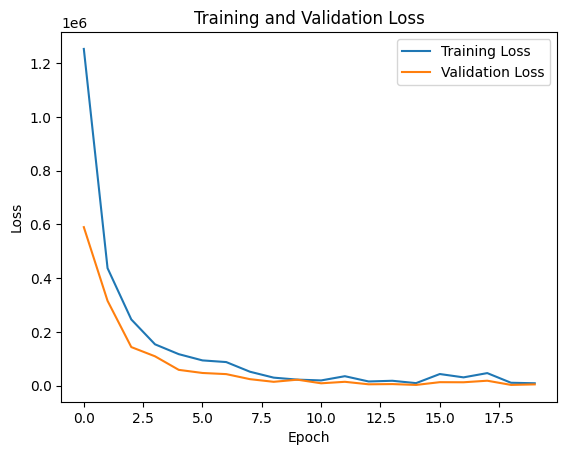

In [28]:
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1000)  # Set y-axis limit to 0.1

plt.title('Training and Validation Loss')
plt.legend()
# plt.show()
plt.savefig('loss.png')


In [9]:


# Set the model to evaluation mode
model.eval()

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and ground truth labels
predictions = []
ground_truths = []

# Initialize list to store confidence scores
confidence_scores = []

# Iterate through the test dataset
for images, labels in test_loader:
    # Move images and labels to the GPU if available
    if torch.cuda.is_available():
        images, labels = images.to(device), labels.to(device)
    
    # Forward pass the images through the model
    with torch.no_grad():
        outputs = model(images)
    
    # Compute confidence scores using softmax probabilities
    softmax_probs = F.softmax(outputs, dim=1)
    max_probs, preds = torch.max(softmax_probs, dim=1)
    
    # Append confidence scores and predictions to lists
    confidence_scores.extend(max_probs.cpu().numpy())
    predictions.extend(preds.cpu().numpy())
    
    # Convert one-hot encoded labels to class indices
    ground_truths.extend(labels.argmax(dim=1).cpu().numpy())
# Calculate the confusion matrix
conf_matrix = confusion_matrix(ground_truths, predictions)

# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)
# Calculate accuracy from confusion matrix
accuracy = (conf_matrix.diagonal().sum() / conf_matrix.sum()) * 100

print(f'Accuracy: {accuracy:.2f}%')



Confusion Matrix:
[[195   0   0   0   0   0   2   0]
 [  0 235   0   0   0   0   0   0]
 [  0   0 205   0   0   0   0   0]
 [  0   0   0 198   0   0   0   0]
 [  0   0   0   0 197   0   0   0]
 [  0   0   0   0   0 187   0   0]
 [  1   0   0   0   0   0 177   0]
 [  0   0   0   0   1   0   0 202]]
Accuracy: 99.75%


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the figure as an image
# plt.show()

# Print accuracy
print(f'Accuracy: {accuracy:.2f}%')


NameError: name 'conf_matrix' is not defined

<Figure size 800x600 with 0 Axes>

## Contour Detection and Font Type Classification

I am using contours to extract "Hello World" text, then I am using pytesseract, an OCR software to detect the letters and put bounding box on top of it, then I am adding some padding to make it the required size to pass into the DeepCNN model.

 Once it classifies each letter, the font classification is based on maximum class prediction of each letters. The confidence is averaged over top confidence of each letters.
 I am using OpenCV to save the bounding boxc with prediction score and font class

In [13]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pytesseract

model3 = torch.load('font_classifier3.pth') # Load the model for testing
# Define transformation to resize and normalize the image
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

font_classes = ['Arimo', 'Dancing Script', 'Fredoka One', 'Oswald', 'PT Serif', 'Patua One', 'Roboto', 'Ubuntu']
# Load the CNN model
# model = torch.load('font_classifier.pth')
model3.eval()

# Read the image
img = cv2.imread("output_images/hello_1.png")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Performing OTSU threshold
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# Specify structure shape and kernel size
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 24))

# Applying dilation on the threshold image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


for cnt in contours:
    all_predictions = []
    all_confidences = []
    #extract bounding box coordinates
    x, y, w, h = cv2.boundingRect(cnt)
    # Extract region of interest (ROI) from the grayscale image
    roi = gray[y:y+h, x:x+w]

    # Use pytesseract to get bounding box coordinates of individual characters
    boxes = pytesseract.image_to_boxes(roi)
    
    # Iterate over each bounding box detected by pytesseract
    for b in boxes.splitlines():
        b = b.split(' ')
        char_x, char_y, char_w, char_h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
        
        # Extract individual character from ROI based on bounding box coordinates
        char_roi = roi[char_y:char_h, char_x:char_w]
        
        # # Plot the character region of interest
        # Add padding to make the character ROI 64x64
        pad_x = max(0, (64 - char_roi.shape[1]) // 2)
        pad_y = max(0, (64 - char_roi.shape[0]) // 2)
        if char_roi.shape[0] < 64 and char_roi.shape[1] < 64:
            # Add padding to make the character ROI 64x64
            pad_x = max(0, (64 - char_roi.shape[1]) // 2)
            pad_y = max(0, (64 - char_roi.shape[0]) // 2)
            char_roi = np.pad(char_roi, ((pad_y, 64 - char_roi.shape[0] - pad_y), (pad_x, 64 - char_roi.shape[1] - pad_x)), mode='constant', constant_values=255)
        
        # Convert the character ROI to PIL Image and apply transformation
        char_roi_pil = Image.fromarray(char_roi)

        char_roi_tensor = transform(Image.fromarray(char_roi))

        # Add batch dimension and move to GPU if available
        char_roi_tensor = char_roi_tensor.unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Forward pass through the model
        with torch.no_grad():
            output = model3(char_roi_tensor)
        
        # Convert output probabilities to predicted class and calculate confidence
        pred_probs = F.softmax(output, dim=1)
        confidence, pred_class = torch.max(pred_probs, dim=1)
        
        # Append predictions and confidences
        all_predictions.append(pred_class.item())
        all_confidences.append(confidence.item())
    
    # Determine the majority vote of predictions
    majority_prediction = max(set(all_predictions), key=all_predictions.count)
    
    # Calculate confidence as the mean confidence of all predictions
    confidence = sum(all_confidences) / len(all_confidences)
    
    # Print the majority prediction and confidence
    print("Majority Prediction:", font_classes[majority_prediction])
    print("Confidence:", confidence)
    text = f'{font_classes[majority_prediction]} ({confidence * 100:.2f}%)'

    cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Draw bounding box
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.imwrite("output_with_predictions.jpg", img)



Majority Prediction: Roboto
Confidence: 0.9123639789494601
Majority Prediction: Dancing Script
Confidence: 0.9999957746929593
Majority Prediction: Dancing Script
Confidence: 0.9999957746929593
Majority Prediction: Ubuntu
Confidence: 0.9296061504970897
Majority Prediction: Roboto
Confidence: 0.9123639789494601
Majority Prediction: Dancing Script
Confidence: 0.9999957746929593
Majority Prediction: Roboto
Confidence: 0.9123639789494601
Majority Prediction: Roboto
Confidence: 0.9123639789494601
Majority Prediction: Ubuntu
Confidence: 0.9701025106690147


True